# Resumen metricas

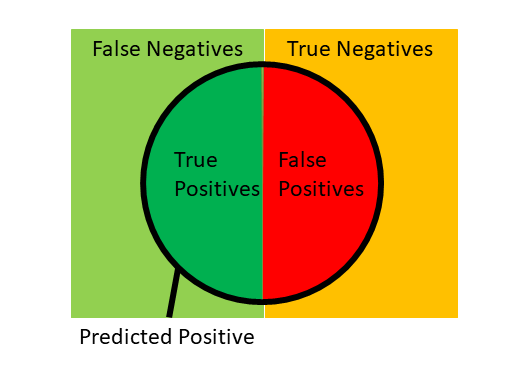
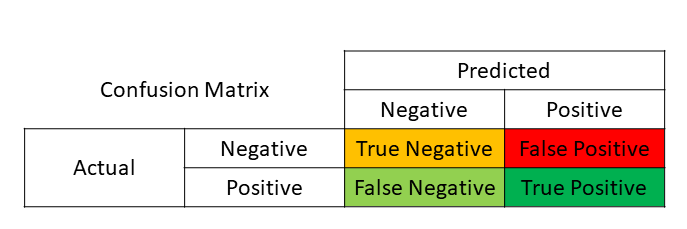
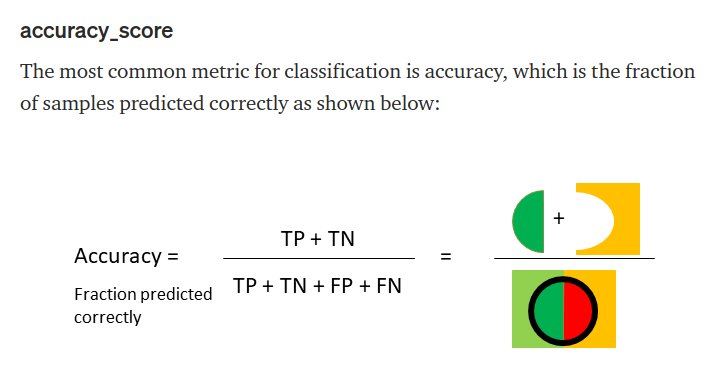
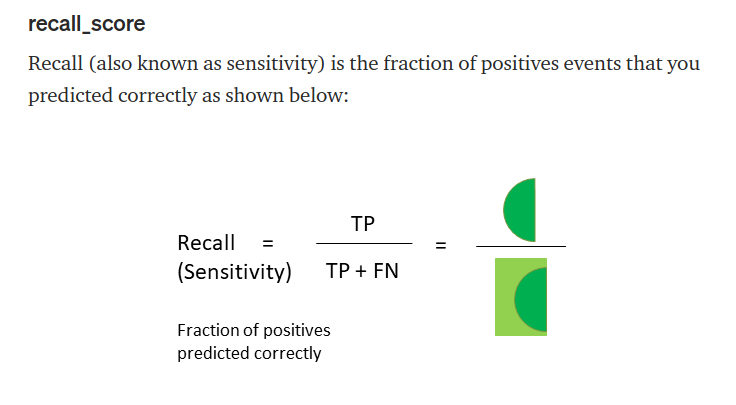
### falta el Kappa
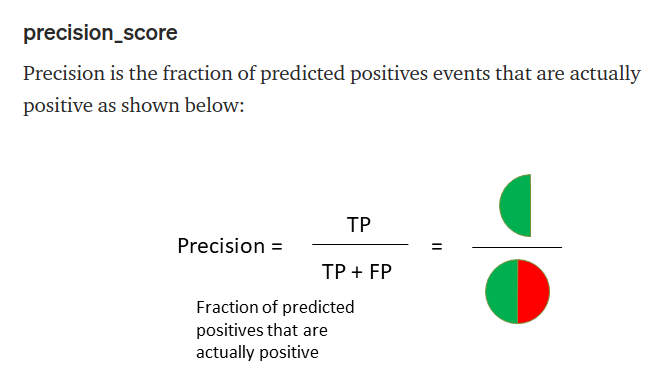
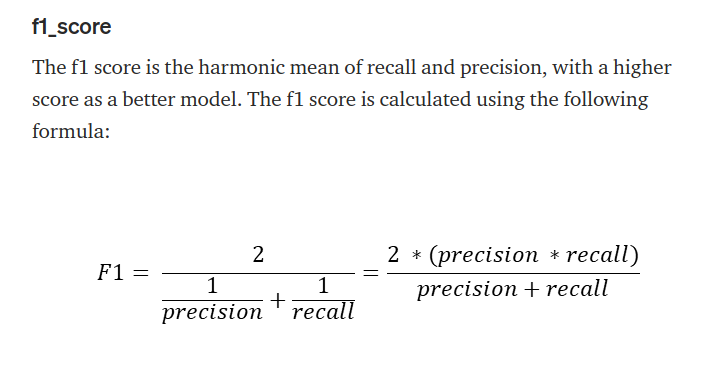
> [Fuente](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019)


In [25]:
import metnum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/akima/.virtualenvs/mn/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/akima/Documents/mn/repo/tp2
-- Configuring done
-- Generating done
-- Build files have been written to: /home/akima/

In [32]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca

In [5]:
df_train = pd.read_csv("../data/train.csv")
df_train = df_train[5000:10000] # Probando, borrar esta linea dsp

In [6]:
df_train["label"].value_counts(normalize=True)

1    0.1074
7    0.1066
3    0.1058
9    0.1034
2    0.1000
0    0.0994
4    0.0980
6    0.0974
8    0.0946
5    0.0874
Name: label, dtype: float64

# Dividir entre train y val

In [7]:
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

In [8]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


## Correr

In [50]:
alpha_step = 5
alpha_max = 71

k_max = 41
k_step = 5

X_train_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)

In [51]:
datos = []

for alpha in range(1, alpha_max+1, alpha_step):
    for k in range(1, k_max+1, k_step):
        X_train_pca, X_val_pca = X_train_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_val_pca)

        acc = accuracy_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred, average = 'weighted')
        precision = precision_score(y_val, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average = 'weighted')

        datos.append({'alpha': alpha, 'k':k, 'accuracy':acc, 'recall':recall, 'precision':precision, 'kappa':kappa, 'f1':f1})

        #print(f"alpha-k:{alpha}-{k}\n\t Accuracy: {acc}\n\t Recall: {recall}\n\t Kappa: {kappa}\n\t F1-Score: {f1}\n")

datosDF = pd.DataFrame(datos)

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[ 91,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0, 102,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   5,  91,   2,   1,   0,   1,   4,   1,   0],
       [  1,   1,   0, 103,   0,   0,   1,   1,   2,   0],
       [  0,   6,   0,   0,  64,   0,   6,   0,   0,  11],
       [  0,   3,   0,   3,   1,  79,   2,   0,   1,   3],
       [  0,   0,   0,   0,   0,   1, 110,   0,   0,   0],
       [  0,  10,   1,   0,   0,   0,   0,  88,   0,   5],
       [  0,   4,   0,   4,   0,   6,   3,   0,  82,   2],
       [  2,   1,   0,   1,   1,   0,   0,   2,   0,  87]])

In [73]:
datosIndexed =  datosDF.set_index(['k', 'alpha']).unstack(level=0)

In [74]:
datosIndexed['accuracy']

k,1,6,11,16,21,26,31,36,41
alpha,,,,,,,,,
1,0.240,0.259,0.271,0.274,0.274,0.282,0.286,0.296,0.290
6,0.756,0.804,0.797,0.799,0.799,0.800,0.806,0.799,0.791
11,0.891,0.894,0.889,0.886,0.880,0.878,0.883,0.879,0.874
16,0.928,0.931,0.927,0.915,0.917,0.914,0.910,0.909,0.906
21,0.935,0.942,0.925,0.931,0.929,0.920,0.921,0.921,0.916
26,0.933,0.942,0.935,0.924,0.928,0.928,0.914,0.910,0.911
31,0.935,0.939,0.935,0.930,0.929,0.924,0.921,0.915,0.917
36,0.938,0.936,0.936,0.930,0.926,0.921,0.917,0.916,0.915
41,0.940,0.939,0.936,0.927,0.927,0.921,0.920,0.917,0.915


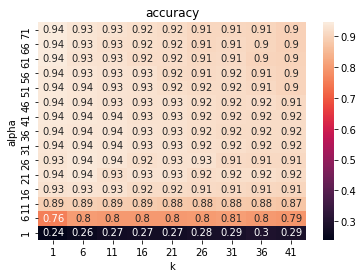

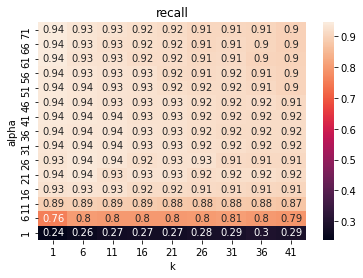

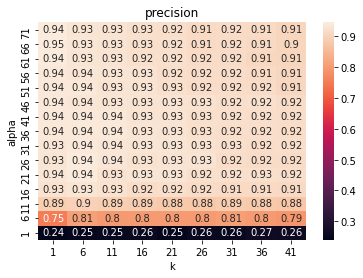

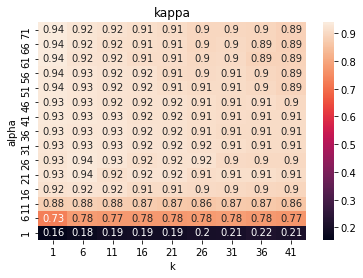

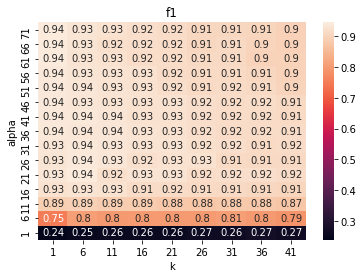

In [82]:
for metric in ['accuracy', 'recall', 'precision', 'kappa', 'f1']:
    sns.heatmap(datosIndexed[metric], annot = True).invert_yaxis()
    plt.title(metric)
    plt.show()